<a href="https://colab.research.google.com/github/bdknguyen/npb-198-final-project/blob/main/semantic_rep_network_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import scipy.cluster.hierarchy as shc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

In [2]:
# Mount drive to access files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/NPB 198 Final Project

Mounted at /content/drive
/content/drive/My Drive/NPB 198 Final Project


# Stage 1: Data Loading/Organization

In [3]:
# Extract output data from IS/ISA/CAN/HAS data csv's into dataframes
is_output = pd.read_csv("sem rep IS data.csv", delimiter=",", header=0, index_col=0)
isa_output = pd.read_csv("sem rep ISA data.csv", delimiter=",", header=0, index_col=0)
can_output = pd.read_csv("sem rep CAN data.csv", delimiter=",", header=0, index_col=0)
has_output = pd.read_csv("sem rep HAS data.csv", delimiter=",", header=0, index_col=0)

In [4]:
# Extracts lists of animals and attributes from dataframes
animals_list = is_output.index.values
attributes_list = is_output.columns.values

# Create list of relation names
relations_list = ["IS", "ISA", "CAN", "HAS"]

In [5]:
# Turn dataframes into tensors for outputs
is_output_numpy = is_output.to_numpy()
isa_output_numpy = isa_output.to_numpy()
can_output_numpy = can_output.to_numpy()
has_output_numpy = has_output.to_numpy()

In [6]:
# Make lists of animal and relation inputs

animal_inputs = [[1,0,0,0,0,0,0,0], # grizzly bear
                [0,1,0,0,0,0,0,0], # black bear
                [0,0,1,0,0,0,0,0], # bald eagle
                [0,0,0,1,0,0,0,0], # golden eagle
                [0,0,0,0,1,0,0,0], # salmon
                [0,0,0,0,0,1,0,0], # trout
                [0,0,0,0,0,0,1,0], # caribou
                [0,0,0,0,0,0,0,1]] # moose

relation_inputs = [[1,0,0,0], # IS
                  [0,1,0,0], # ISA
                  [0,0,1,0], # CAN
                  [0,0,0,1]] # HAS

In [7]:
# Stuff inputs and outputs for each relation into lists of tuples
# Then stuff lists into DataLoaders
# Format of data: ((Animal input, relation input), relation-specific output)

is_IO = []
for i in range(8):
  is_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[0]).float()),
      torch.tensor(is_output_numpy[i]).float())
      )

isa_IO = []
for i in range(8):
  isa_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[1]).float()),
      torch.tensor(isa_output_numpy[i]).float())
      )
  
can_IO = []
for i in range(8):
  can_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[2]).float()),
      torch.tensor(can_output_numpy[i]).float())
      )
  
has_IO = []
for i in range(8):
  has_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[3]).float()),
      torch.tensor(has_output_numpy[i]).float())
      )

# Combine all inputs/outputs into one unified list
all_IO = is_IO + isa_IO + can_IO + has_IO

is_IO_DataLoader = DataLoader(is_IO, batch_size=1, shuffle=False)
isa_IO_DataLoader = DataLoader(isa_IO, batch_size=1, shuffle=False)
can_IO_DataLoader = DataLoader(can_IO, batch_size=1, shuffle=False)
has_IO_DataLoader = DataLoader(has_IO, batch_size=1, shuffle=False)
all_IO_DataLoader = DataLoader(all_IO, batch_size=1, shuffle=True)

In [8]:
# Sets order of relation dataloaders for testing each relation
relation_DL_order = [is_IO_DataLoader,
                     isa_IO_DataLoader,
                     can_IO_DataLoader,
                     has_IO_DataLoader]

# Stage 2: Network Setup

In [9]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(8, 8) # representation layer
    self.fc2 = nn.Linear(12, 15) # hidden layer
    self.fc3 = nn.Linear(15, 39) # attribute layer

    # Initialize weights for all layers
    torch.nn.init.uniform_(self.fc1.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc2.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc3.weight, a=-0.9, b=0.9)
  
  def forward(self, data):
    # Extract animal/relation inputs from "data" tuple
    # x = animal, y = relation
    x, y = data

    # Animal input to representation layer, save representation data in var
    fc1 = self.fc1(x)
    x = torch.sigmoid(fc1)

    # Concatenate rep layer output and relation input
    combined = torch.cat((x, y), dim=1)

    # Send concatenated input to hidden layer
    fc2 = self.fc2(combined)
    x = torch.sigmoid(fc2)

    # Hidden layer to attribute layer
    fc3 = self.fc3(x)
    output = torch.sigmoid(fc3)
    return output

# Stage 3: Training and Testing

In [10]:
# Set learning rate, momentum, and num of epochs
learning_rate = 0.1
momentum = 0
num_epochs = 3500

# Make network and set up optimizer for backpropagation
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0)

In [11]:
# Set up function for extracting representation layer data
def get_hidden_features(x, layer):
    activation = {}

    def get_activation(name):
        def hook(network, input, output):
          activation[name] = output.detach()
        return hook

    rep_list = []
    hook = network.fc1.register_forward_hook(get_activation(layer))
    passthru = network(x)
    rep_list.append(activation[layer])
    hook.remove()
    return rep_list[0]

In [12]:
# Set up function for network training
def train(epoch):
  network.train()
  train_loss = 0

  # Run through all data in dataloader
  for data, target in all_IO_DataLoader:
    output = network(data)
    loss = nn.CrossEntropyLoss()
    loss_amount = loss(output, target)
    train_loss += loss_amount

    optimizer.zero_grad()
    loss_amount.backward()
    optimizer.step()

  # Print out training progress for each relation dataset every 350 epochs
  train_loss /= len(all_IO_DataLoader)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("Train Epoch {}: \tLoss: {:.6f}".format(
      epoch, train_loss))

In [13]:
# Set up function for testing
def test(epoch):
  network.eval()

  with torch.no_grad():
    if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
      for i in range(4):
        test_loss = 0

        for index, (data, target) in enumerate(relation_DL_order[i]):
          output = network(data)
          loss = nn.CrossEntropyLoss()
          test_loss += loss(output, target)

        test_loss /= len(relation_DL_order[i])
        print("Test: {}\tAverage loss = {:.6f}".format(relations_list[i], 
                                                      test_loss))  

In [14]:
# Create bar graphs of animal representation data
def create_rep_graphs(epoch):
  # Create list of values for representation data
  rep_values_list = []

  with torch.no_grad():
    fig, ax = plt.subplots(8, sharex=True, figsize=(8,35))
    fig.suptitle(f"Animal Representation Data, Epoch {epoch}", y=0.905)
    for index, (data, target) in enumerate(relation_DL_order[0]):
      labels = np.arange(8)
      values = get_hidden_features(data, 'fc1')
      values = values.numpy()[0]
      rep_values_list.append(values)
      ax[index].bar(labels, values)
      ax[index].set_title(animals_list[index].upper())
  
  return rep_values_list

In [15]:
# Create dendrograms of representation data at certain epoch
def create_dendrogram(rep_values_list, epoch):
  # Create dataframe of representation values
  rep_values_df = pd.DataFrame(np.array(rep_values_list), index=animals_list)

  # Make the graph
  plt.figure(figsize=(12, 6), dpi= 80)  
  plt.title(f"Animal Hierarchy, Epoch {epoch}", fontsize=22)
  dend = shc.dendrogram(shc.linkage(rep_values_df, method='ward'), 
                        labels=animals_list, color_threshold=100)
  plt.xticks(fontsize=12)
  plt.show()  

Train Epoch 1: 	Loss: 11.063924
Test: IS	Average loss = 8.093417
Test: ISA	Average loss = 15.064832
Test: CAN	Average loss = 10.275829
Test: HAS	Average loss = 10.492471




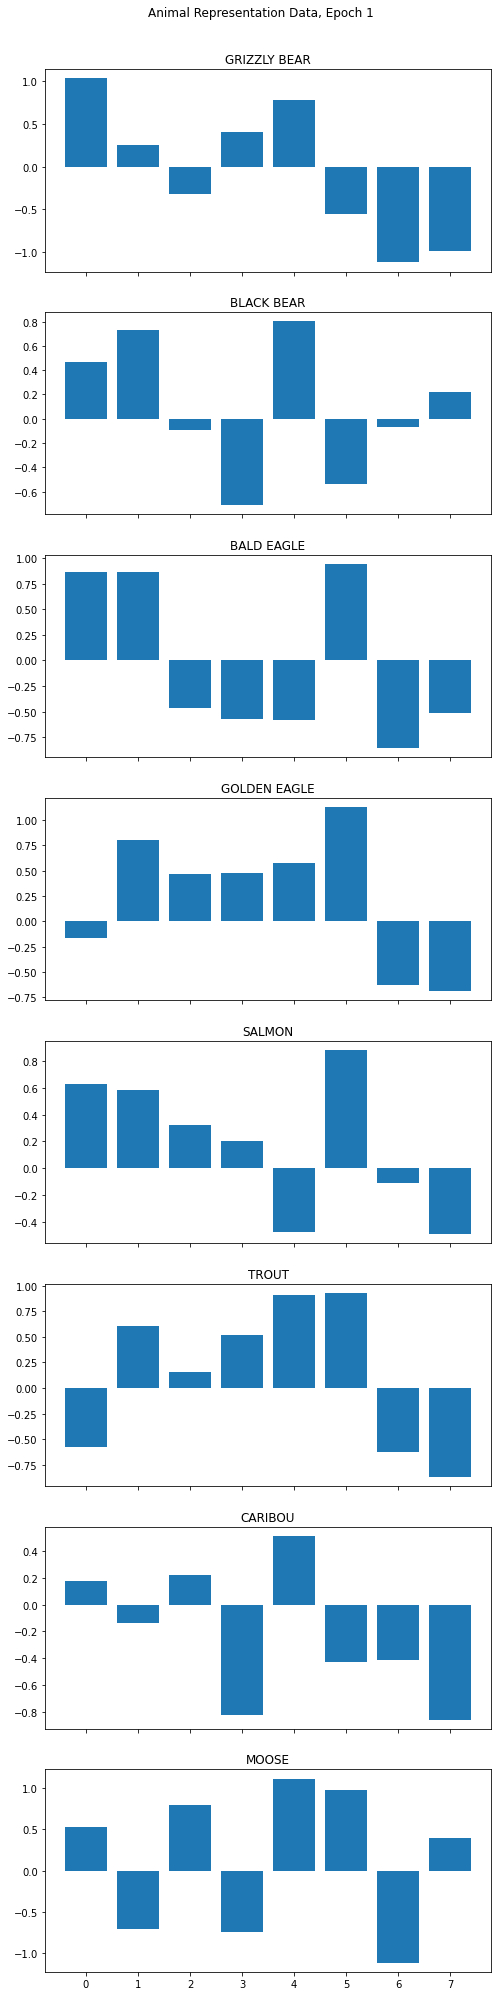

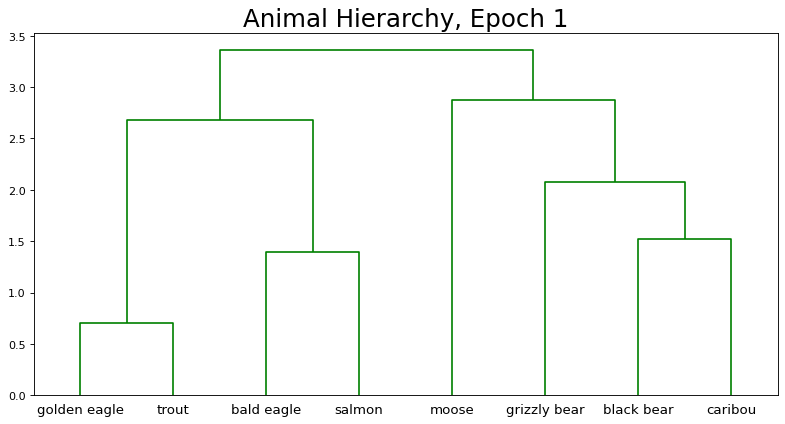

Train Epoch 175: 	Loss: 9.223782
Test: IS	Average loss = 6.786462
Test: ISA	Average loss = 12.727690
Test: CAN	Average loss = 8.773142
Test: HAS	Average loss = 8.584062


Train Epoch 350: 	Loss: 9.073786
Test: IS	Average loss = 6.728044
Test: ISA	Average loss = 12.420490
Test: CAN	Average loss = 8.678631
Test: HAS	Average loss = 8.441708


Train Epoch 525: 	Loss: 8.908447
Test: IS	Average loss = 6.665906
Test: ISA	Average loss = 12.066000
Test: CAN	Average loss = 8.614042
Test: HAS	Average loss = 8.269899


Train Epoch 700: 	Loss: 8.770638
Test: IS	Average loss = 6.610851
Test: ISA	Average loss = 11.844930
Test: CAN	Average loss = 8.568863
Test: HAS	Average loss = 8.048504


Train Epoch 875: 	Loss: 8.667725
Test: IS	Average loss = 6.530398
Test: ISA	Average loss = 11.655462
Test: CAN	Average loss = 8.530626
Test: HAS	Average loss = 7.944249




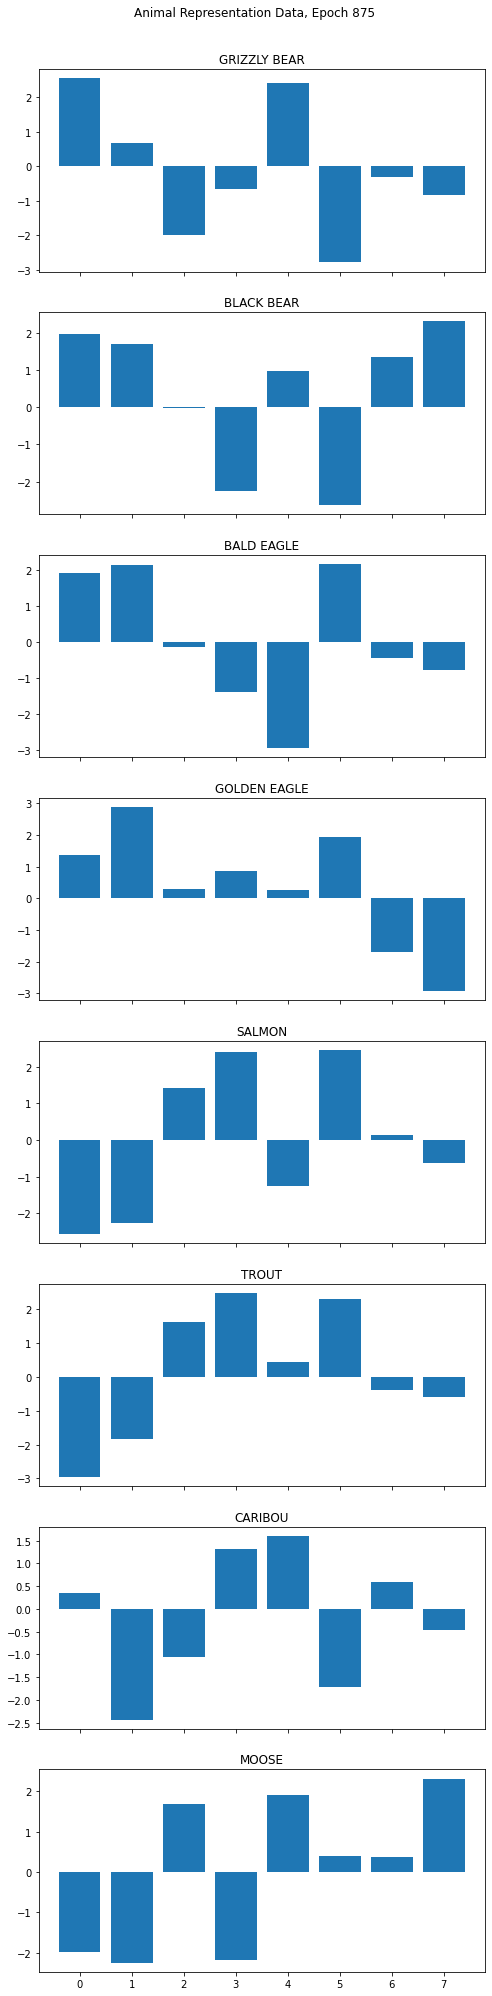

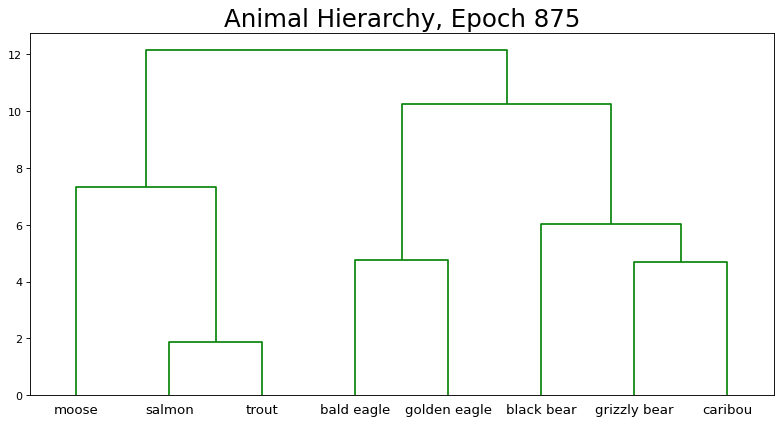

Train Epoch 1050: 	Loss: 8.594590
Test: IS	Average loss = 6.478152
Test: ISA	Average loss = 11.525982
Test: CAN	Average loss = 8.471402
Test: HAS	Average loss = 7.898275


Train Epoch 1225: 	Loss: 8.558049
Test: IS	Average loss = 6.454243
Test: ISA	Average loss = 11.458903
Test: CAN	Average loss = 8.440424
Test: HAS	Average loss = 7.876072


Train Epoch 1400: 	Loss: 8.537232
Test: IS	Average loss = 6.436587
Test: ISA	Average loss = 11.427781
Test: CAN	Average loss = 8.421012
Test: HAS	Average loss = 7.861972


Train Epoch 1575: 	Loss: 8.523816
Test: IS	Average loss = 6.427828
Test: ISA	Average loss = 11.409904
Test: CAN	Average loss = 8.405812
Test: HAS	Average loss = 7.850597


Train Epoch 1750: 	Loss: 8.513903
Test: IS	Average loss = 6.422266
Test: ISA	Average loss = 11.398196
Test: CAN	Average loss = 8.395095
Test: HAS	Average loss = 7.839178




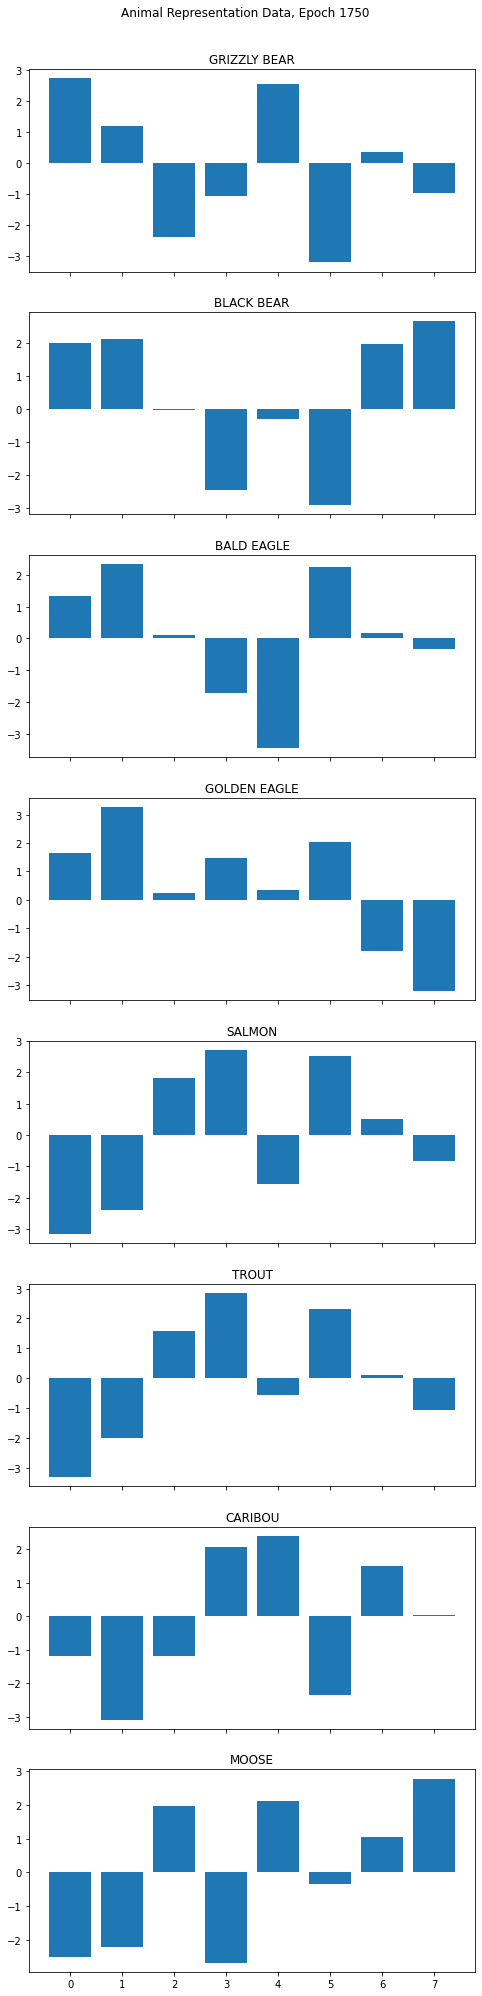

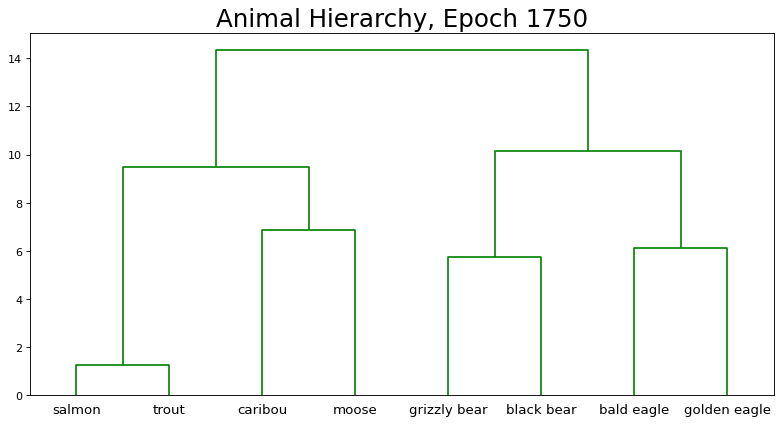

Train Epoch 1925: 	Loss: 8.504783
Test: IS	Average loss = 6.418513
Test: ISA	Average loss = 11.390239
Test: CAN	Average loss = 8.388858
Test: HAS	Average loss = 7.820840


Train Epoch 2100: 	Loss: 8.498977
Test: IS	Average loss = 6.415513
Test: ISA	Average loss = 11.383852
Test: CAN	Average loss = 8.384933
Test: HAS	Average loss = 7.811152


Train Epoch 2275: 	Loss: 8.494848
Test: IS	Average loss = 6.412889
Test: ISA	Average loss = 11.378803
Test: CAN	Average loss = 8.382135
Test: HAS	Average loss = 7.805218


Train Epoch 2450: 	Loss: 8.491145
Test: IS	Average loss = 6.408287
Test: ISA	Average loss = 11.374890
Test: CAN	Average loss = 8.380141
Test: HAS	Average loss = 7.800899


Train Epoch 2625: 	Loss: 8.469726
Test: IS	Average loss = 6.326831
Test: ISA	Average loss = 11.373465
Test: CAN	Average loss = 8.380033
Test: HAS	Average loss = 7.797917




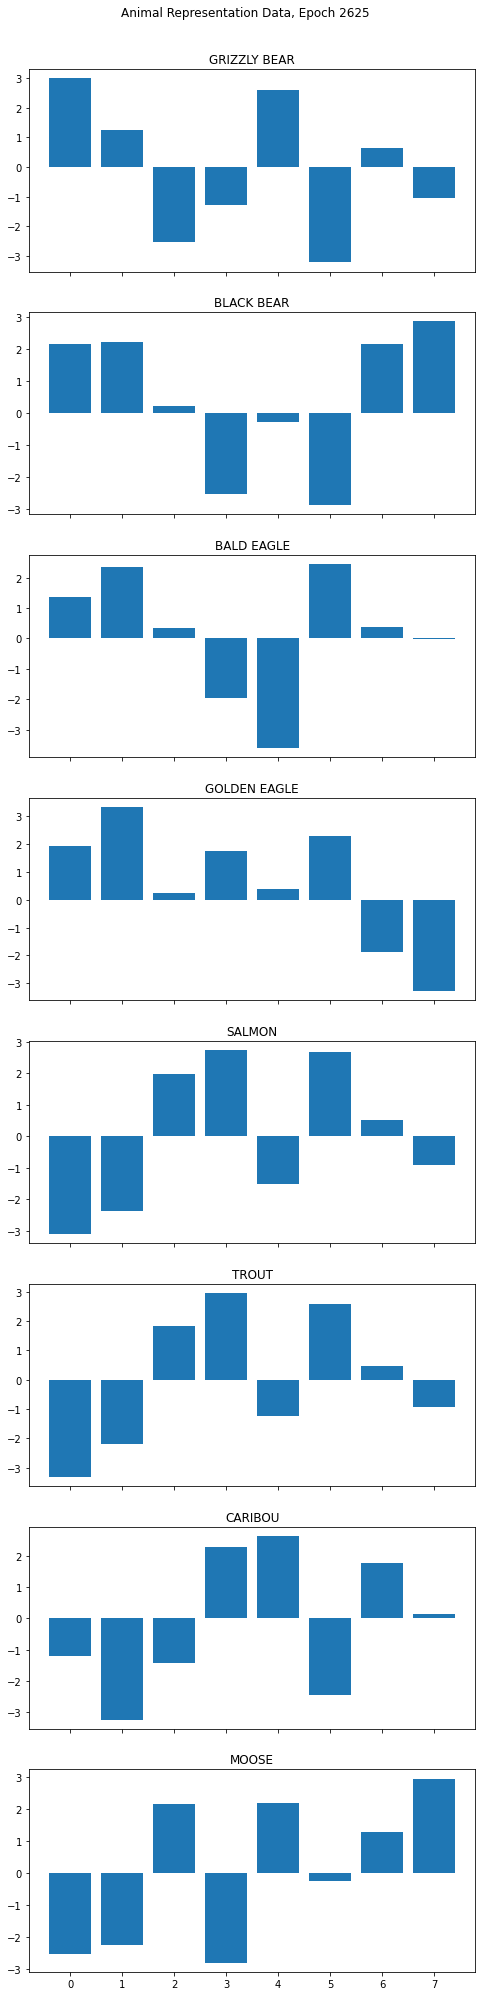

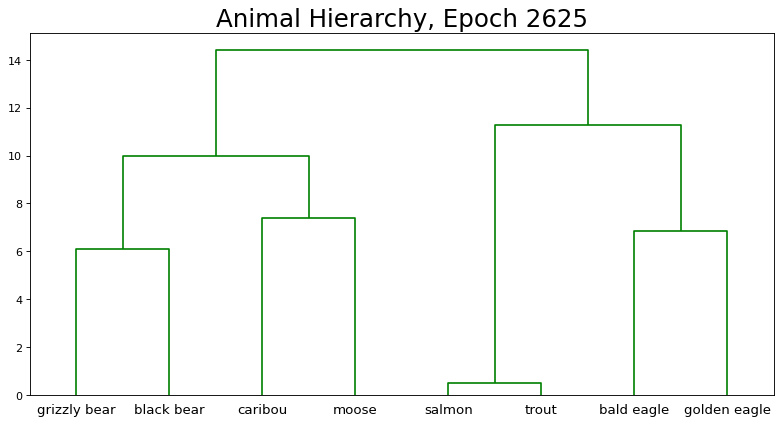

Train Epoch 2800: 	Loss: 8.464491
Test: IS	Average loss = 6.318942
Test: ISA	Average loss = 11.370066
Test: CAN	Average loss = 8.377713
Test: HAS	Average loss = 7.790845


Train Epoch 2975: 	Loss: 8.460842
Test: IS	Average loss = 6.313962
Test: ISA	Average loss = 11.367468
Test: CAN	Average loss = 8.376309
Test: HAS	Average loss = 7.785328


Train Epoch 3150: 	Loss: 8.457834
Test: IS	Average loss = 6.308831
Test: ISA	Average loss = 11.365382
Test: CAN	Average loss = 8.375234
Test: HAS	Average loss = 7.781660


Train Epoch 3325: 	Loss: 8.455709
Test: IS	Average loss = 6.305786
Test: ISA	Average loss = 11.363580
Test: CAN	Average loss = 8.374243
Test: HAS	Average loss = 7.779055


Train Epoch 3500: 	Loss: 8.454082
Test: IS	Average loss = 6.303774
Test: ISA	Average loss = 11.362019
Test: CAN	Average loss = 8.373371
Test: HAS	Average loss = 7.777030




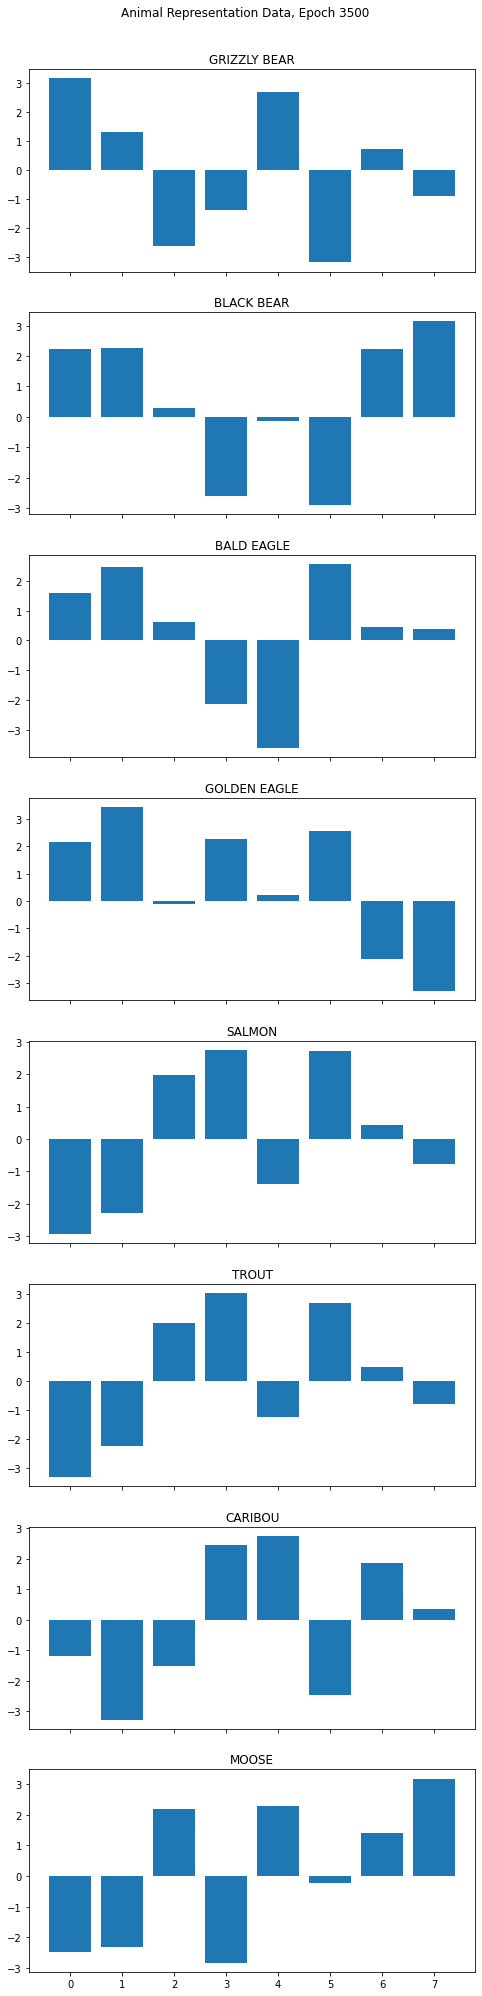

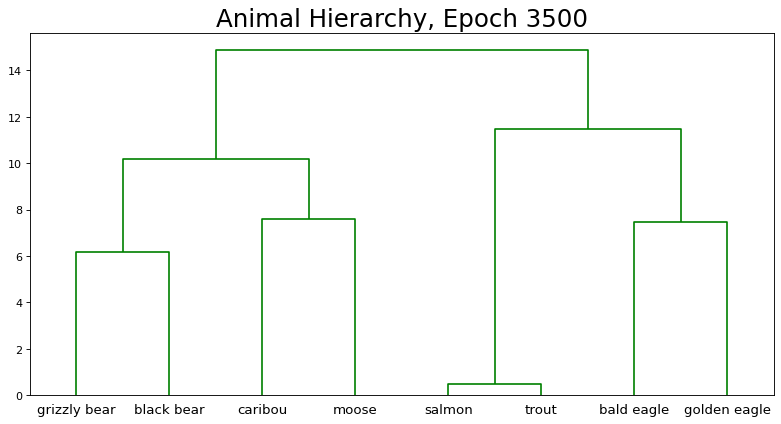

In [16]:
# Commence training and testing
# Also print out representation graphs every 875 epochs
for epoch in range(1, num_epochs + 1):
  train(epoch)
  test(epoch)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("\n")
  if (epoch == 1) or (epoch % (num_epochs // 4) == 0):
    rep_data_list = create_rep_graphs(epoch)
    create_dendrogram(rep_data_list, epoch)

# Stage 4: Visualizations

In [17]:
# Create function for making graphs comparing target vs. actual output
# z: specifying which relation's output should be graphed
def create_output_graphs(z):
  with torch.no_grad():
    print("Results for {}:".format(relations_list[z]))
    for index, (data, target) in enumerate(relation_DL_order[z]):
      x, y = data
      output = network(data)
      fig, axs = plt.subplots(figsize=(22,3))
      plt.tight_layout()
      labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
      axs.plot(labels, output.numpy()[0], 'o', label='output')
      axs.plot(labels, target.numpy()[0], 'o', label='target')
      axs.set_xlabel('\nattributes')
      axs.set_ylabel('value')
      axs.set_title(f"{animals_list[index]}, {relations_list[z]}")
      plt.legend();

Results for IS:


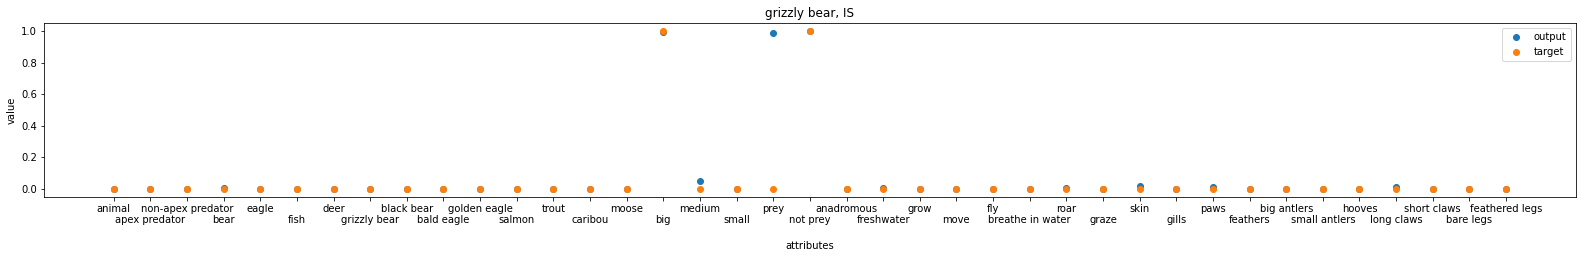

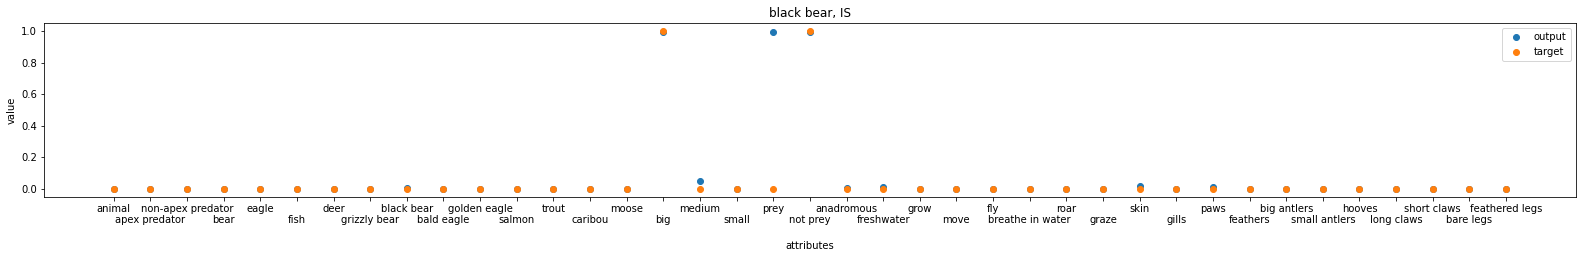

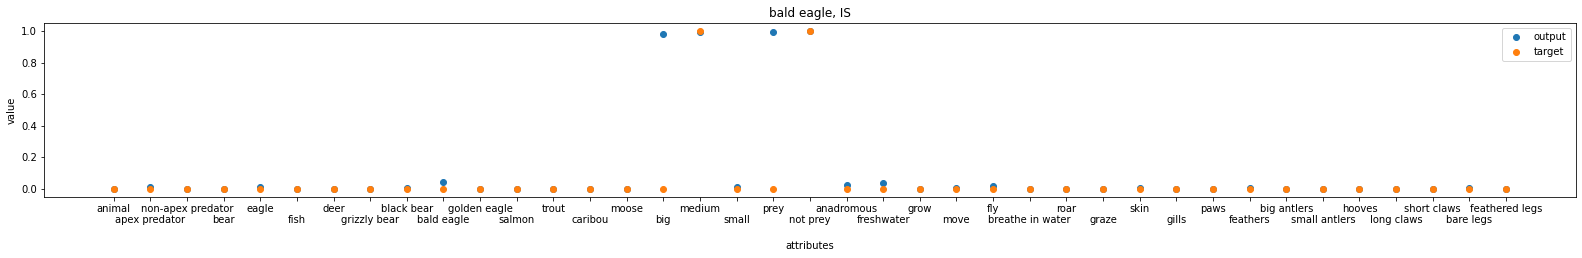

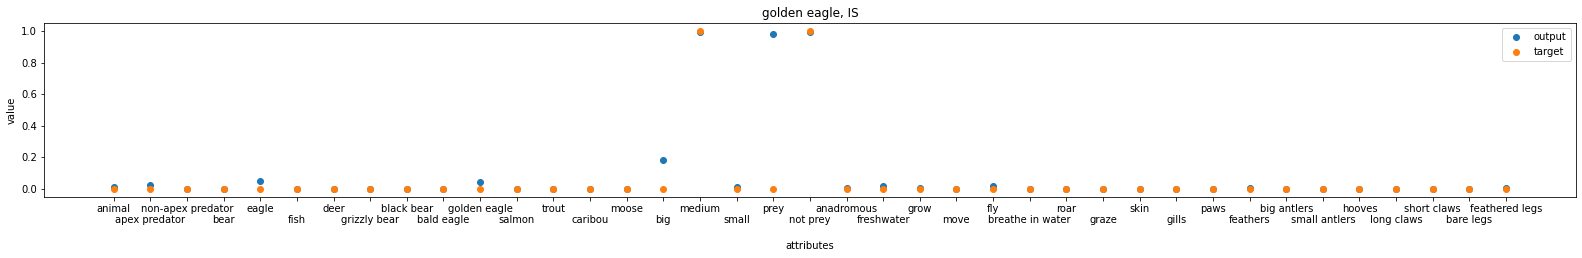

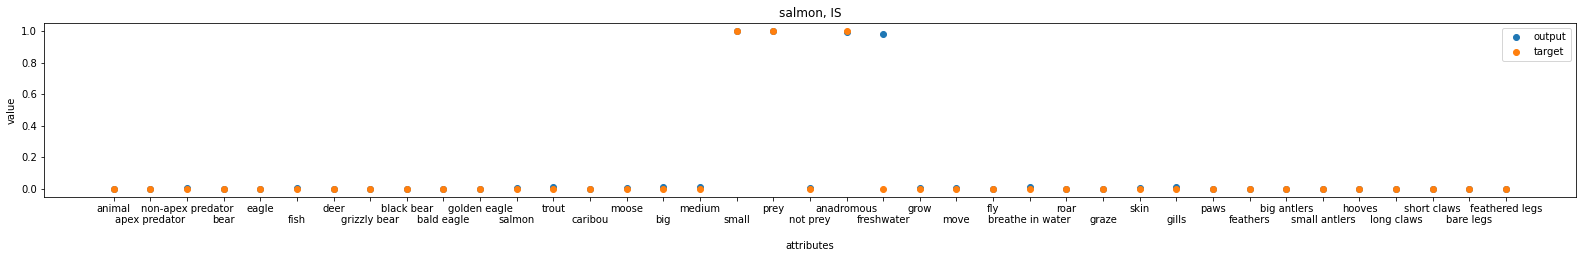

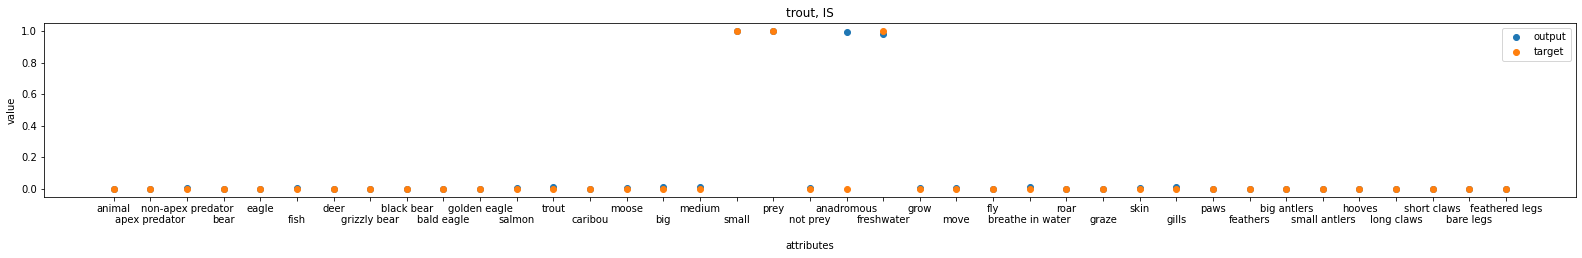

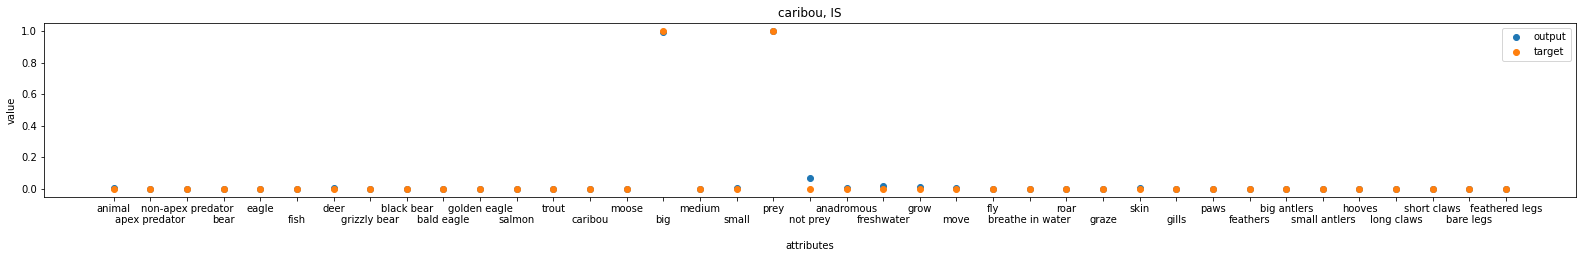

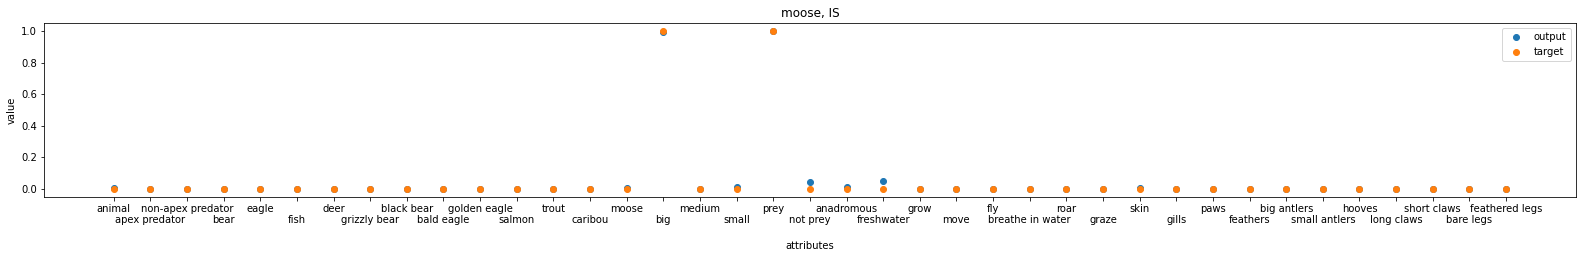

In [18]:
# Display final results (IS) post-training
create_output_graphs(0)

Results for ISA:


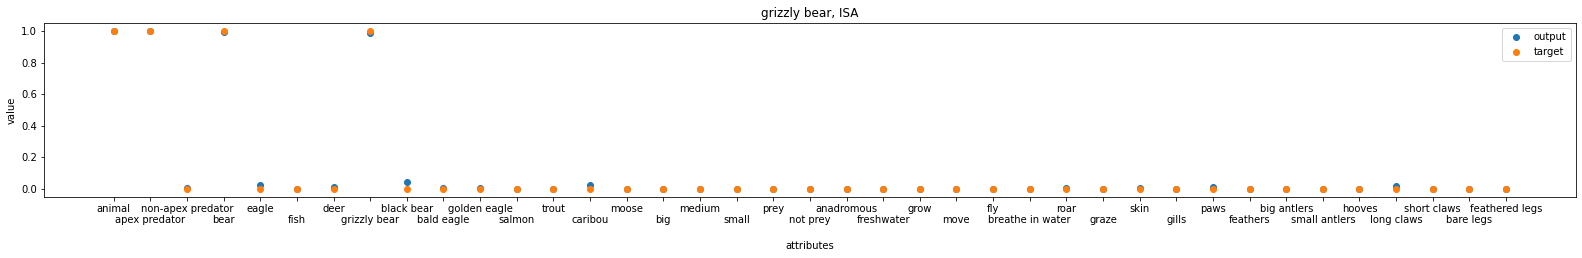

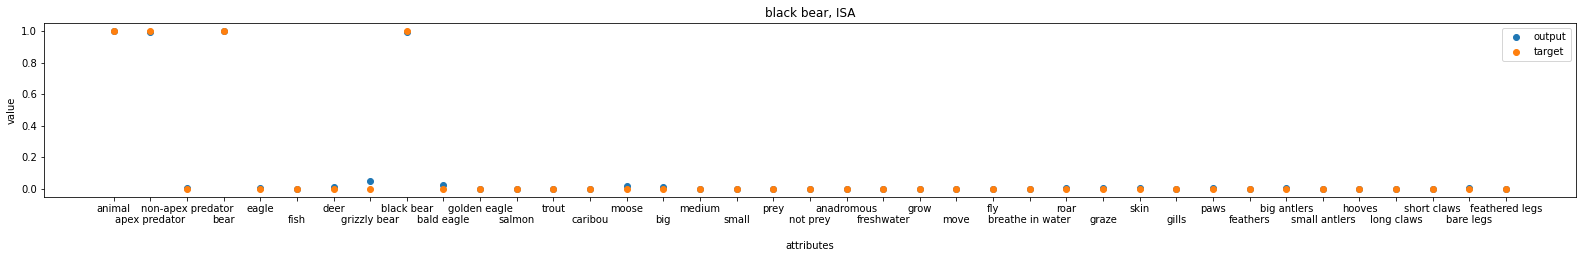

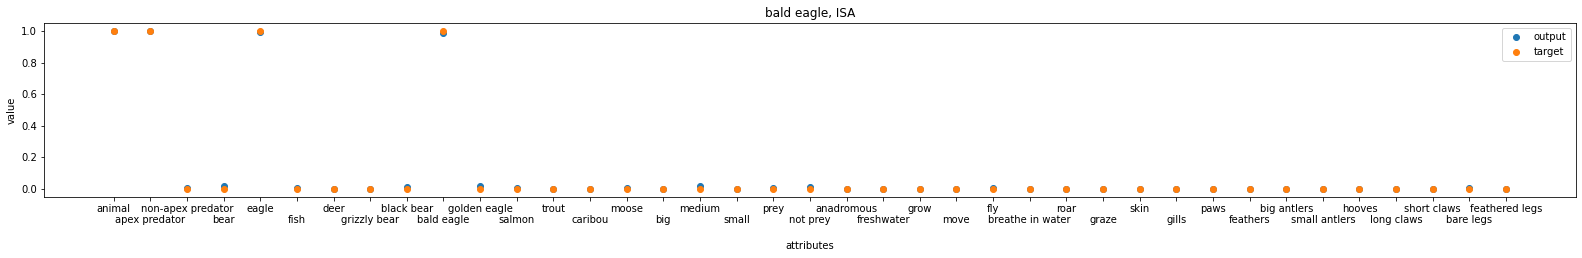

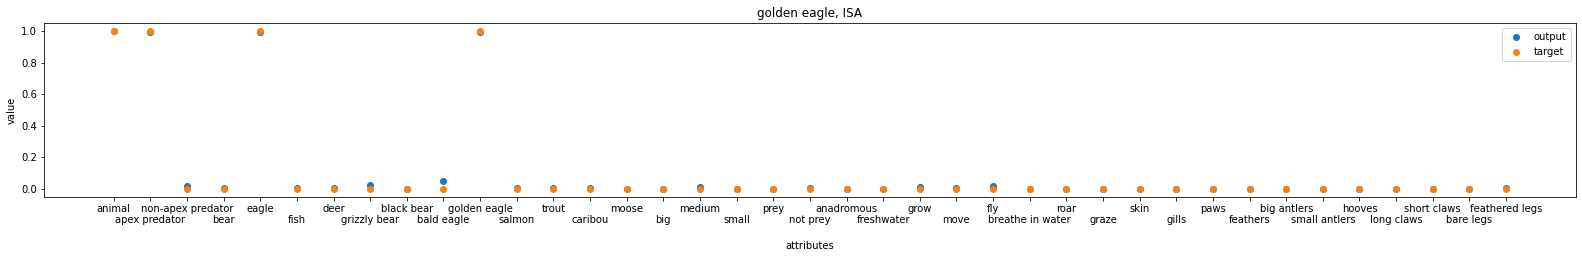

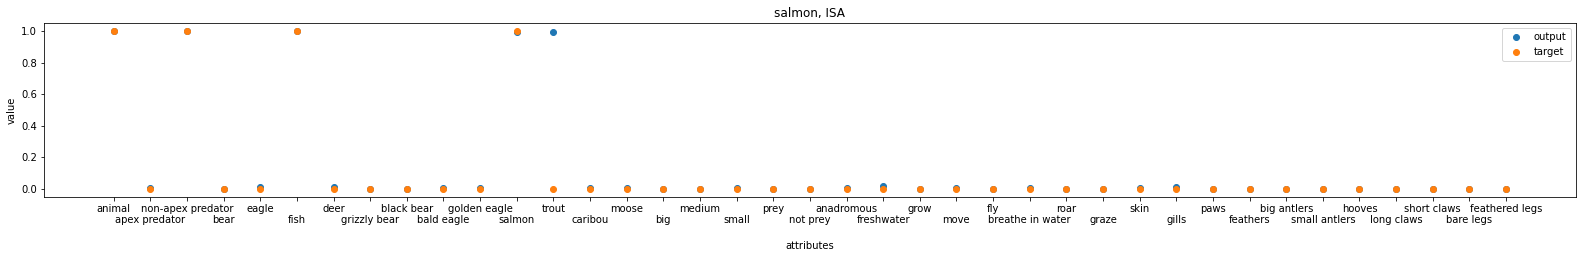

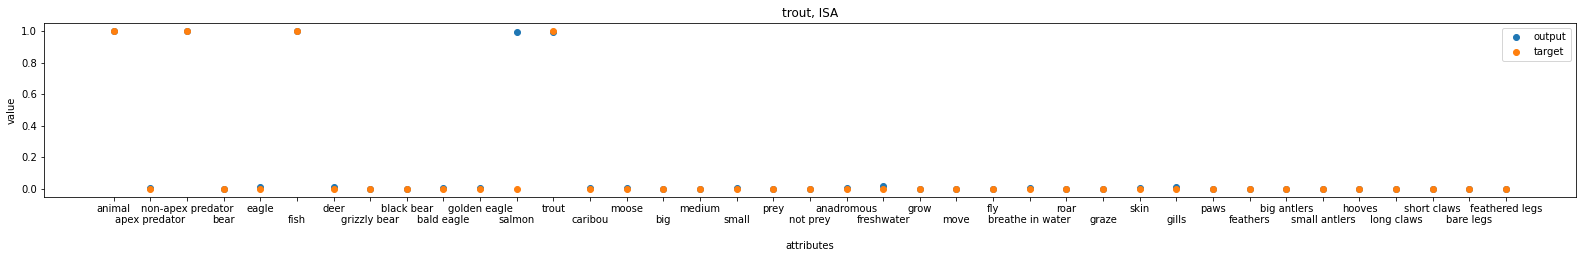

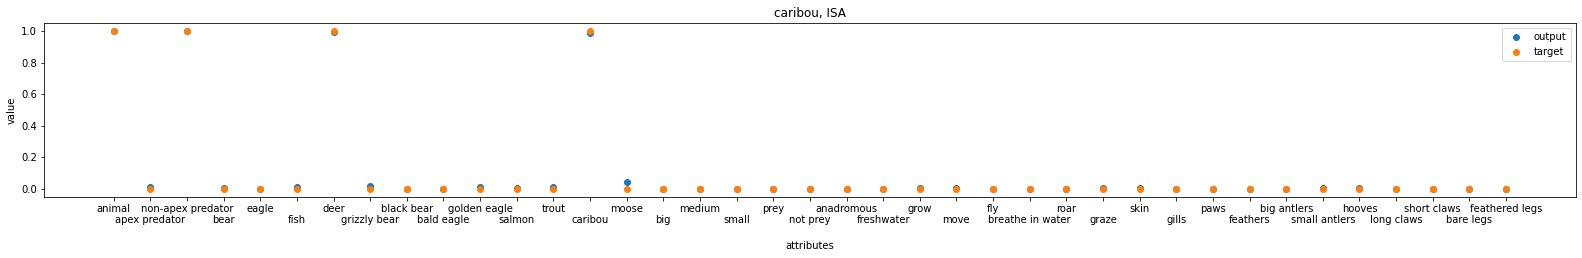

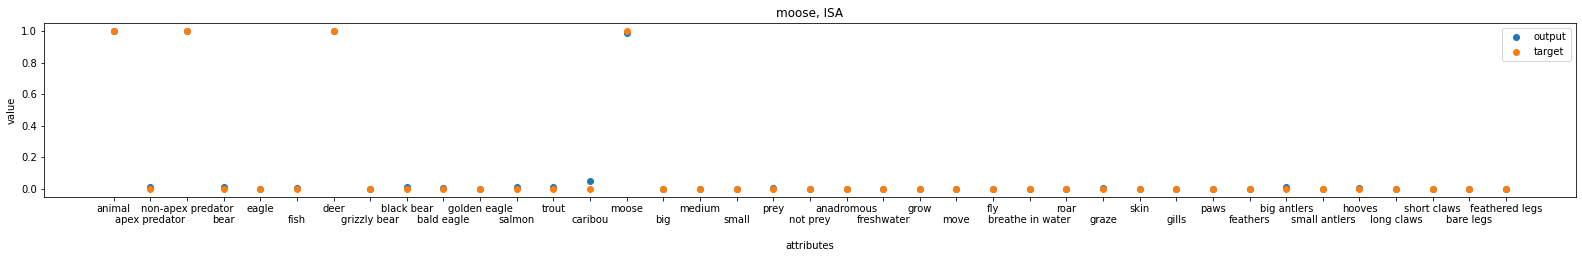

In [19]:
# Display final results (ISA) post-training
create_output_graphs(1)

Results for CAN:


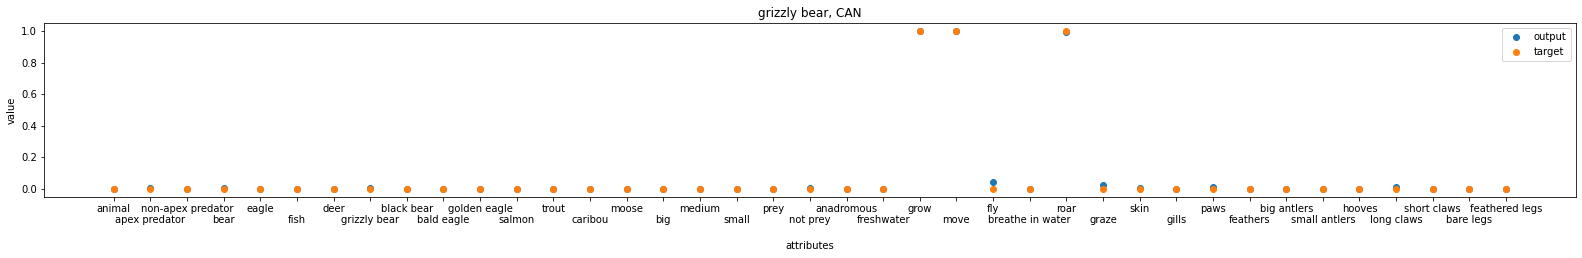

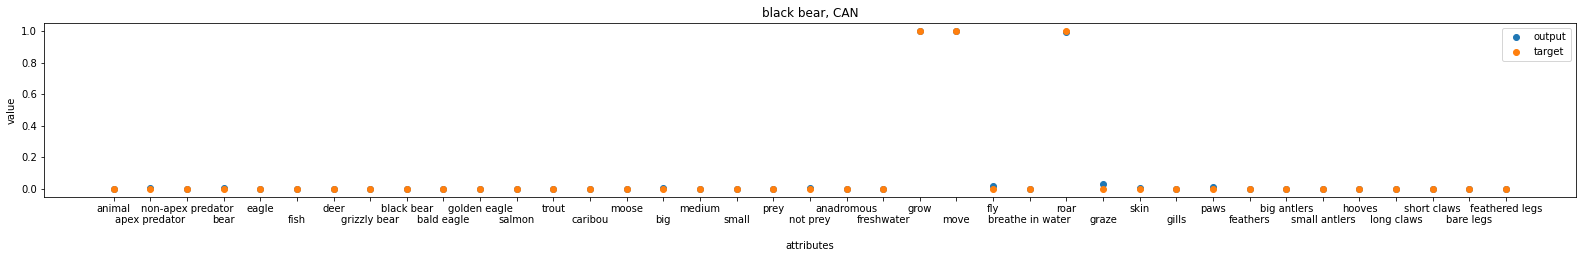

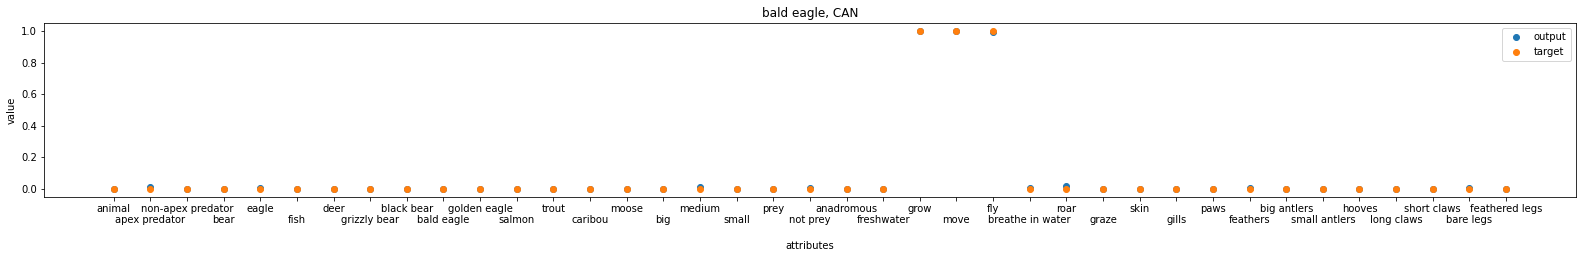

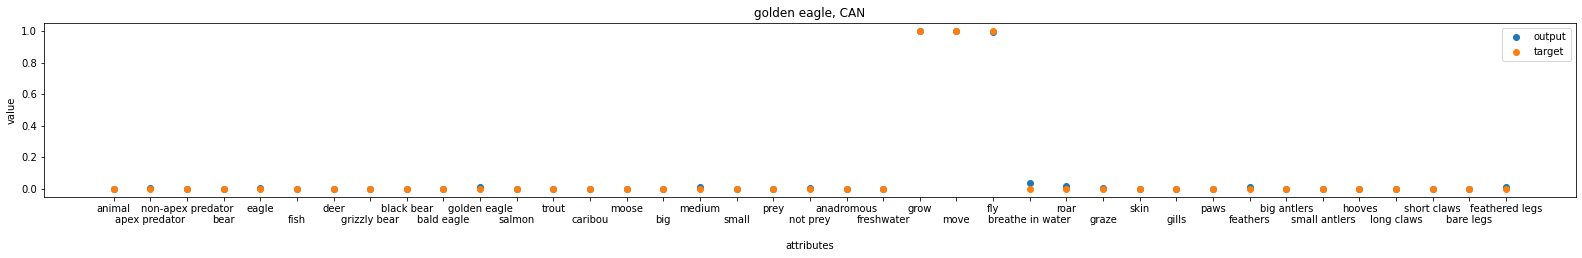

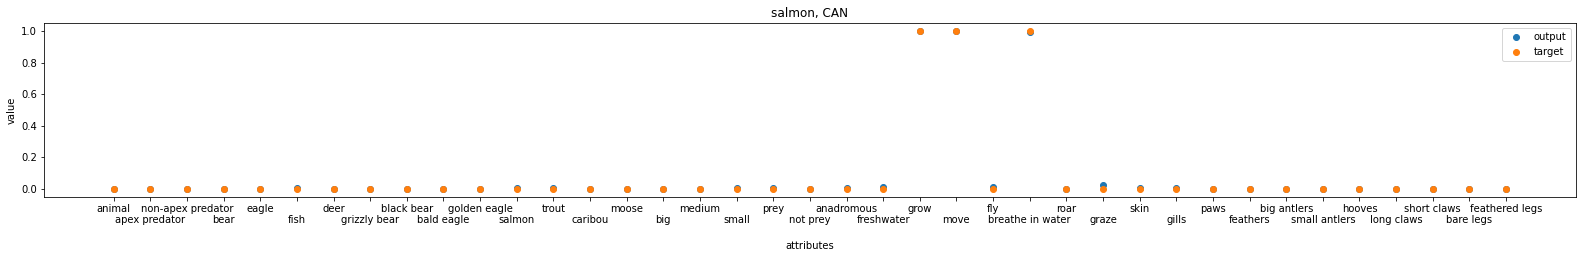

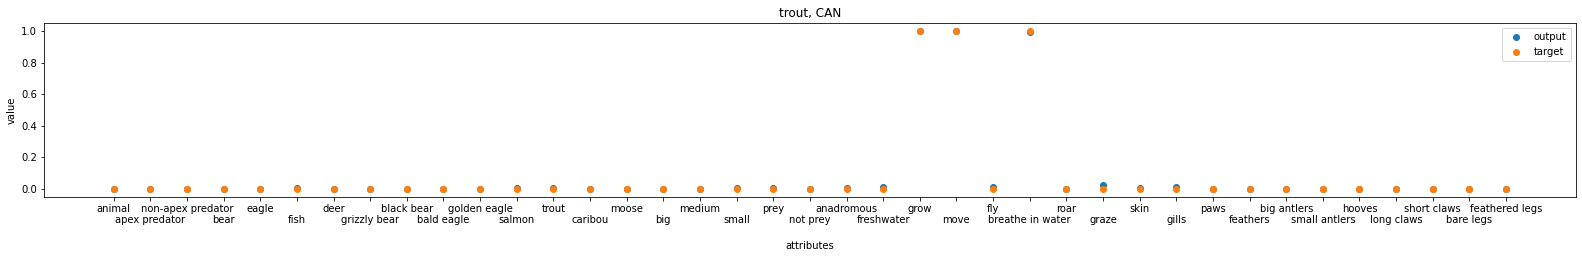

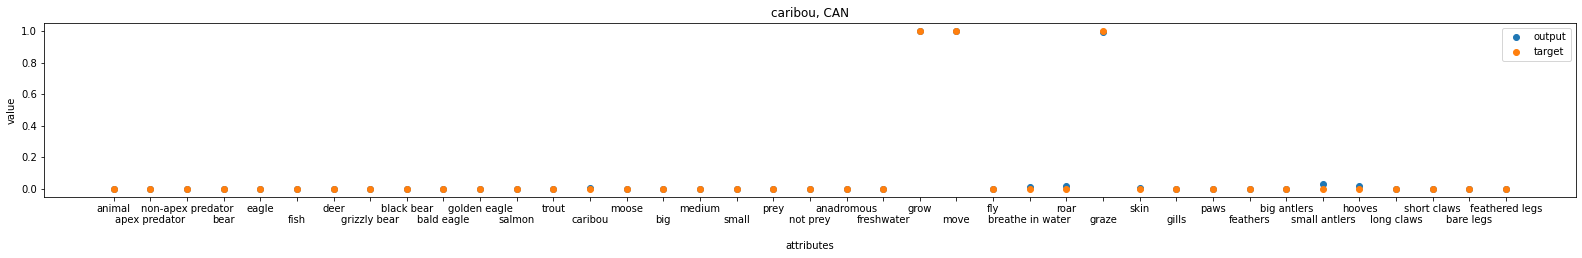

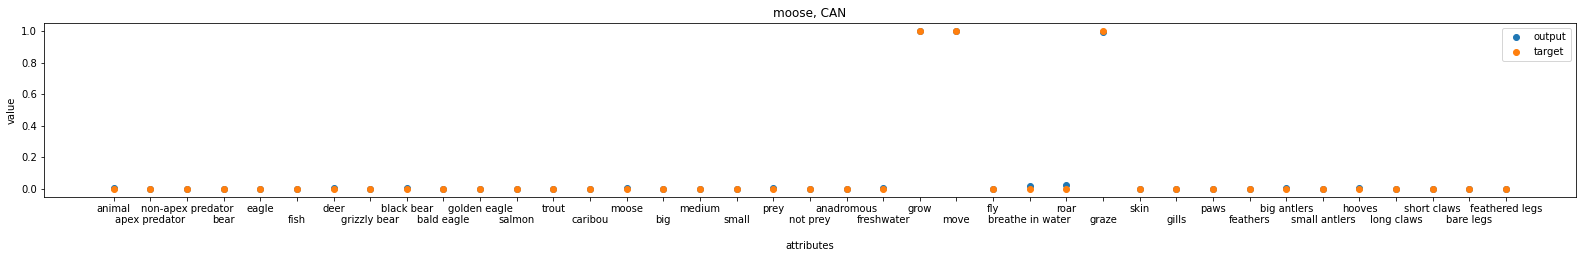

In [20]:
# Display final results (CAN) post-training
create_output_graphs(2)

Results for HAS:


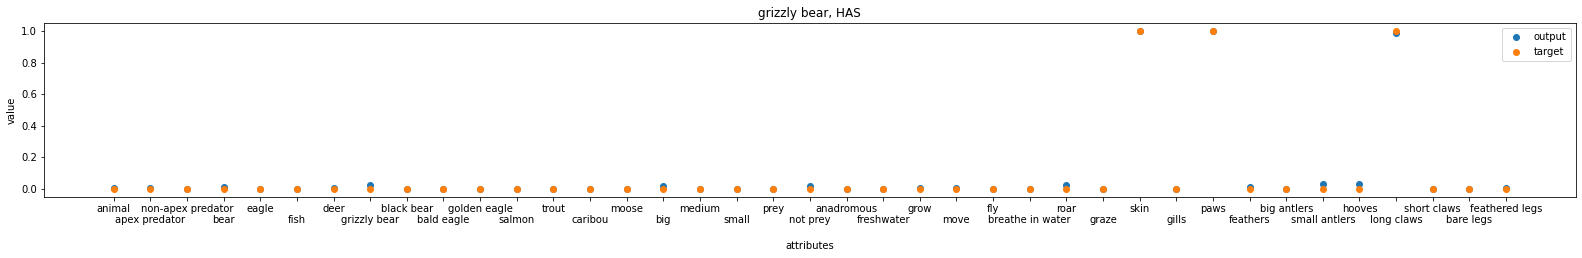

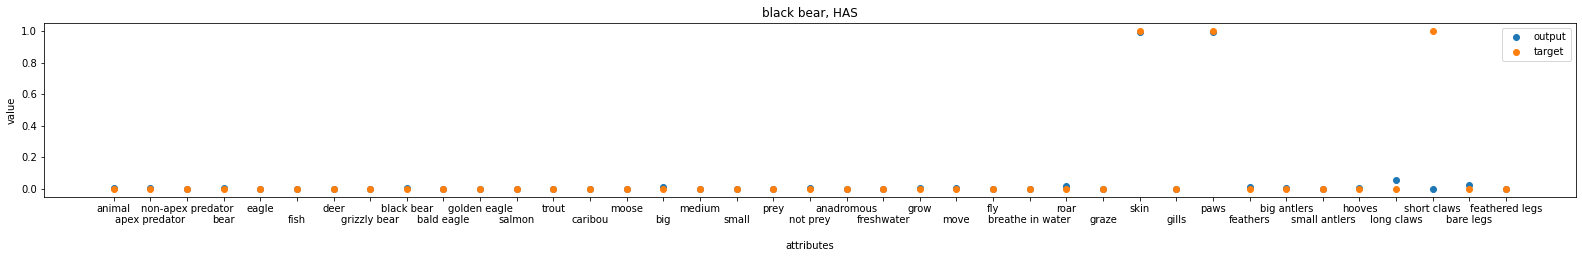

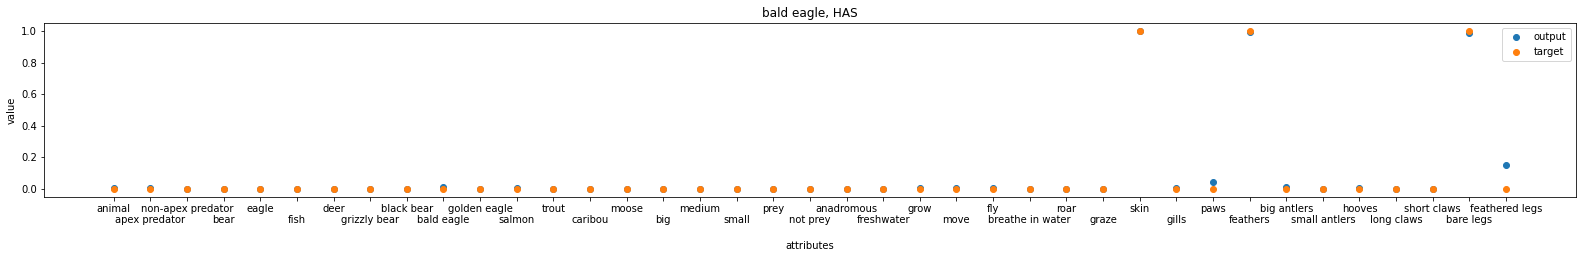

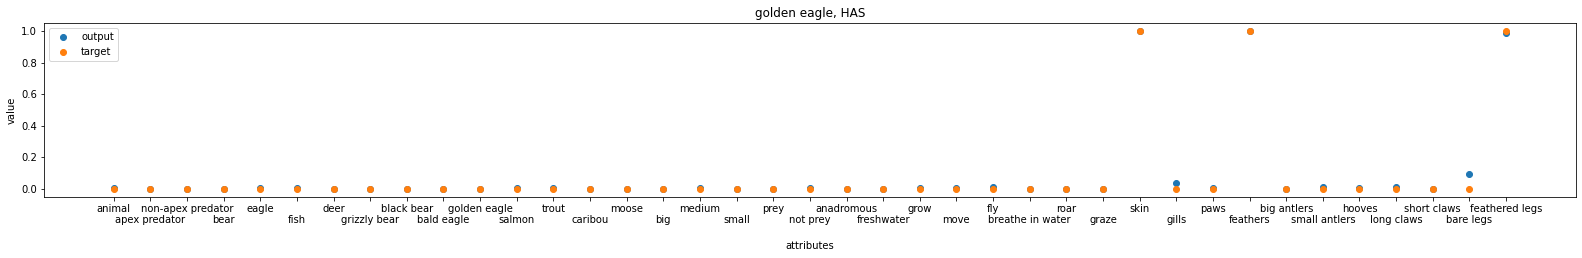

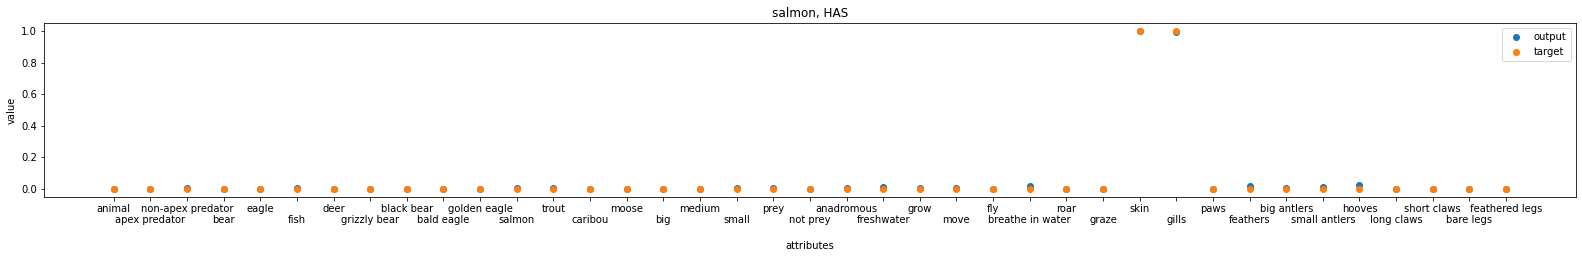

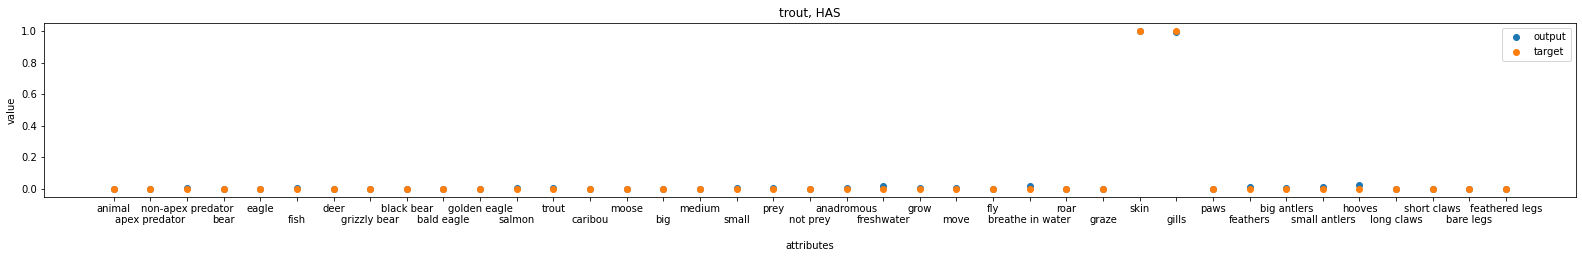

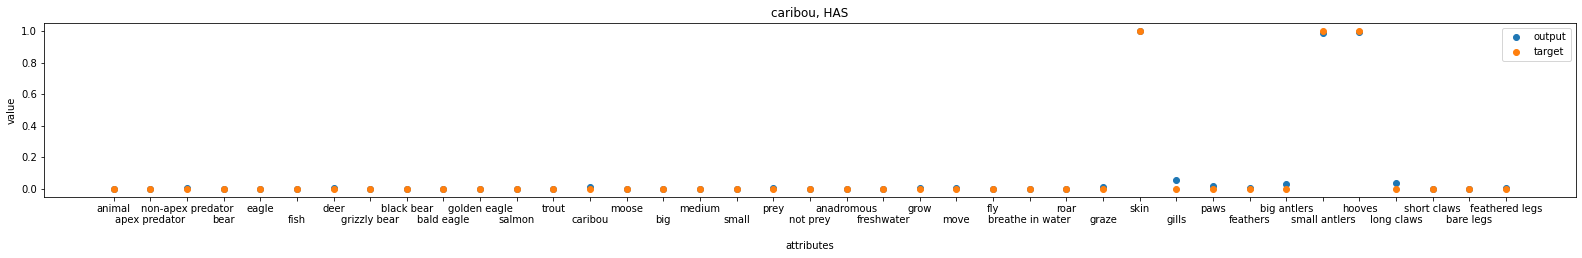

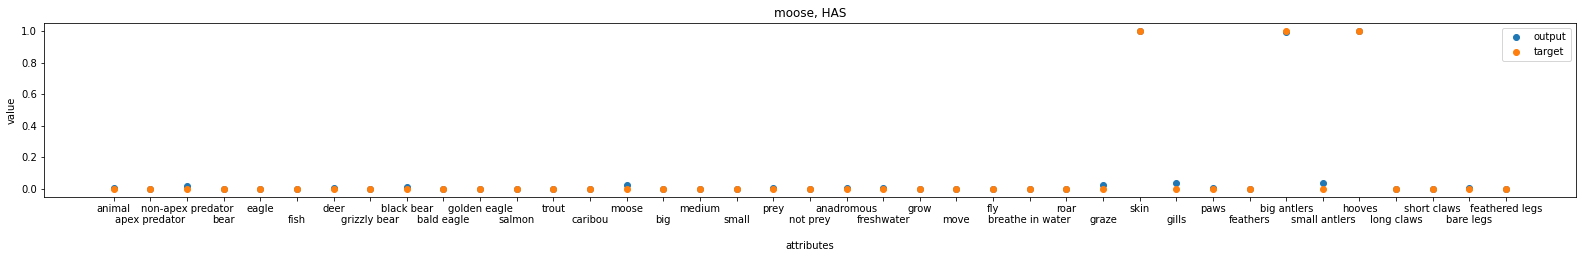

In [21]:
# Display final results (HAS) post-training
create_output_graphs(3)